# Funzioni

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(confusion_matrix=cmn).plot()
  return y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    dataset.drop(columns=columns, inplace=True)
  dataset = pd.concat([dataset, dummies], axis=1)
  return dataset

In [ ]:
def xtab(dataset, index_col, columns_col, normalize_on_idx=False):
  xtab = pd.crosstab(dataset[index_col], dataset[columns_col])
  if normalize_on_idx:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / len(dataset[dataset[index_col] == i])
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

# Parte 1: Analisi

1

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/trainMobile.csv')
dataset.head()

In [ ]:
dataset.info()

In [ ]:
dataset.price_range.value_counts()

2

In [ ]:
dataset.sc_w.value_counts() # discreti

In [ ]:
_ = xtab(dataset, 'sc_w', 'price_range', normalize_on_idx=True)

In [ ]:
dataset.groupby('price_range').mean()[['sc_w']].plot()

In [ ]:
dataset0 = dataset[dataset['sc_w'] > 0]

In [ ]:
dataset0.groupby('price_range').mean()[['sc_w']].plot()

In [ ]:
for p in dataset['price_range'].unique():
  plt.figure()
  plt.title('Price range : {}'.format(p))
  dataset[dataset['price_range'] == p]['battery_power'].plot(kind='hist')

4

In [ ]:
dataset[dataset['four_g'] == 1]['three_g'].describe()

5

In [ ]:
dataset[(dataset['four_g'] == 1) & (dataset['wifi'] == 0) & (dataset['blue'] == 0)
][['four_g', 'wifi', 'blue']].describe()

# Parte 2: Trasformazione e Predizione

1

In [ ]:
train, test = train_test_split(dataset, train_size=0.75, random_state=1)

In [ ]:
X_tr = train.drop(columns='price_range')
y_tr = train.price_range
X_ts = test.drop(columns='price_range')
y_ts = test.price_range

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, LogisticRegression(n_jobs=-1))

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, LogisticRegression(n_jobs=-1))

In [ ]:
"""
DecisionTree fa una stima più accurata ma anche overfitting sui dati di training.
LogisticRegression è meno accurata ma non c'è una differenza sostanziale tra
la predizione sui dati di training e quelli di test
"""

2

In [ ]:
X = dataset.drop(columns='price_range')
y = dataset.price_range

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

In [ ]:
cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

3

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 3, 4, 5]
}

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy',
                  n_jobs=-1, cv=10).fit(X, y)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_ # inferiore all'accuratezza ottenuta in precedenza

0.6859999999999999

4

In [ ]:
X = dataset.drop(columns='price_range')
y = dataset.price_range

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaled = MaxAbsScaler().fit_transform(X)
X_scaled = pd.DataFrame(scaled, columns=X.columns)
X_scaled.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0.421421,0.0,0.733333,0.0,0.052632,0.0,0.109375,0.6,0.940,0.250,0.10,0.010204,0.378378,0.637569,0.473684,0.388889,0.95,0.0,0.0,1.0
1,0.511011,1.0,0.166667,1.0,0.000000,1.0,0.828125,0.7,0.680,0.375,0.30,0.461735,0.994995,0.658079,0.894737,0.166667,0.35,1.0,1.0,0.0
2,0.281782,1.0,0.166667,1.0,0.105263,1.0,0.640625,0.9,0.725,0.625,0.30,0.644388,0.858859,0.651076,0.578947,0.111111,0.45,1.0,1.0,0.0
3,0.307808,1.0,0.833333,0.0,0.000000,0.0,0.156250,0.8,0.655,0.750,0.45,0.620408,0.893894,0.692596,0.842105,0.444444,0.55,1.0,0.0,0.0
4,0.911411,1.0,0.400000,0.0,0.684211,1.0,0.687500,0.6,0.705,0.250,0.70,0.616327,0.606607,0.352926,0.421053,0.111111,0.75,1.0,1.0,0.0


In [ ]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=0.75, random_state=1)

Accuracy: 1.0
Confusion matrix:
 [[384   0   0   0]
 [  0 374   0   0]
 [  0   0 365   0]
 [  0   0   0 377]]


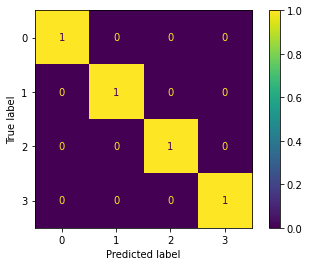

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.818
Confusion matrix:
 [[ 99  17   0   0]
 [  8  97  21   0]
 [  0  21  99  15]
 [  0   0   9 114]]


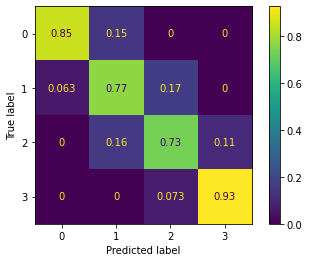

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

5

In [ ]:
dataset1 = dataset.copy()

In [ ]:
dataset1['ram'] = pd.cut(dataset['ram'], bins=4, labels=[1,2,3,4])
dataset1['ram'].value_counts()

3    505
4    502
2    502
1    491
Name: ram, dtype: int64

In [ ]:
X = dataset1.drop(columns='price_range')
y = dataset1.price_range

In [ ]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=0.75, random_state=1)

Accuracy: 1.0
Confusion matrix:
 [[384   0   0   0]
 [  0 374   0   0]
 [  0   0 365   0]
 [  0   0   0 377]]


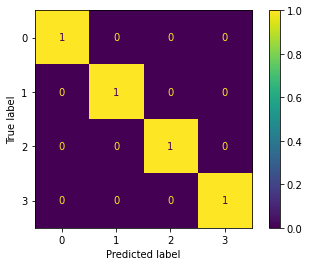

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.762
Confusion matrix:
 [[ 98  17   1   0]
 [ 13  89  24   0]
 [  0  30  88  17]
 [  0   1  16 106]]


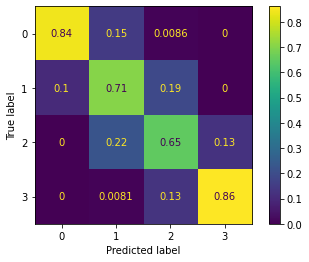

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

6

In [ ]:
dataset.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [ ]:
X = dataset.drop(columns='price_range')
y = dataset['price_range']

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=.75, random_state=1)

In [ ]:
passthrough = dataset.columns.tolist()
passthrough.remove('ram')
passthrough.remove('battery_power')
passthrough.remove('price_range')
passthrough

['blue',
 'clock_speed',
 'dual_sim',
 'fc',
 'four_g',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'sc_h',
 'sc_w',
 'talk_time',
 'three_g',
 'touch_screen',
 'wifi']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, Normalizer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer(
    transformers=[('ram', KBinsDiscretizer(n_bins=4, encode='ordinal'), ['ram']),
                  ('battery_power', KBinsDiscretizer(n_bins=10, encode='ordinal'), ['battery_power']),
                  ('others', 'passthrough', passthrough)])

preprocessing = Pipeline(steps=[('column_transformers', column_transformer),
                                ('scaler', MaxAbsScaler()),
                                ('normalizer', Normalizer())])

pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                           ('model', DecisionTreeClassifier())])

Accuracy: 1.0
Confusion matrix:
 [[384   0   0   0]
 [  0 374   0   0]
 [  0   0 365   0]
 [  0   0   0 377]]


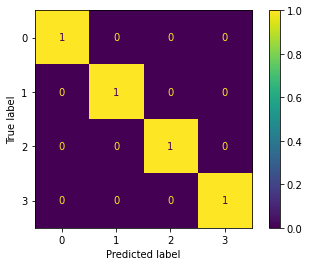

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, pipeline)

Accuracy: 0.708
Confusion matrix:
 [[96 20  0  0]
 [18 81 25  2]
 [ 0 26 85 24]
 [ 0  3 28 92]]


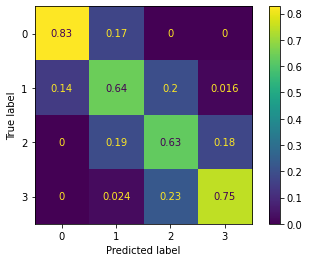

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, pipeline)

7

In [ ]:
test_mobile = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/testMobile.csv')
test_mobile.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [ ]:
test_mobile.drop(columns='id', inplace=True)

In [ ]:
test_mobile.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [ ]:
X_ts = test_mobile

In [ ]:
class_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/class.csv')
y_ts = class_ds['class']

Accuracy: 0.74
Confusion matrix:
 [[210  39   3   0]
 [ 38 165  47   5]
 [  4  44 166  48]
 [  0   4  28 199]]


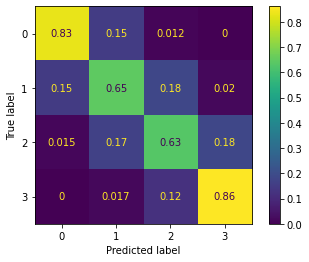

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, pipeline)
# allenare con X e y interi